# Biomarkers for palbociclib - Workbook 2 June 2023 

## Import Data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)


## Palbociclib GDSC with Goncalves et al proteomics (preprocessed & normalised)

In [2]:
# create feature and target 

import DataFunctions as utils

drug_selected = 'Palbociclib'

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc(drug_selected, joined_sin_peptile_exclusion_matrix, gdsc2)

feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)



### Computing Interactors

In [4]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target
import pickle 
import pandas as pd

drug_targets = ['CDK4', 'CDK6']
first_degree_ids = []
first_degree_neighbours = []
second_degree_ids = []
second_degree_neighbours = []
third_degree_ids = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            first_degree_ids.append(ii)
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

print(f'First degree ids size: {len(first_degree_ids)} (With duplicate)')
first_degree_ids = list(set(first_degree_ids))
print(f'First degree ids size: {len(first_degree_ids)} (Without duplicate)')

first_degree_neighbours = list(set(first_degree_neighbours))

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')
# get the second degree neighbours using first_interactors_string_id

for ii in first_degree_ids:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        second_degree_ids.append(sec_ii)
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

print(f'second degree ids size: {len(second_degree_ids)} (With duplicate)')
second_degree_ids = list(set(second_degree_ids))
print(f'second degree ids size: {len(second_degree_ids)} (Without duplicate)')

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')


# get the third degree neighbours using second_interactors_string_id

for ii in second_degree_ids:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        third_degree_ids.append(third_ii)
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

print(f'third degree ids size: {len(third_degree_ids)} (With duplicate)')
third_degree_ids = list(set(third_degree_ids))
print(f'third degree ids size: {len(third_degree_ids)} (Without duplicate)')

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')
# verify a list is unique

def verify_unique_list(l):
    return len(l) == len(set(l))

# find duplicates in the list

def find_duplicates(l):
    return list(set([x for x in l if l.count(x) > 1]))

print(f'first degree neighbours is unique: {verify_unique_list(first_degree_neighbours)}')
print(f'second degree neighbours is unique: {verify_unique_list(second_degree_neighbours)}')
print(f'third degree neighbours is unique: {verify_unique_list(third_degree_neighbours)}')

# print the duplicates in first degree neighbours

print(f'duplicates in first degree neighbours: {find_duplicates(first_degree_neighbours)}')
print(f'duplicates in second degree neighbours: {find_duplicates(second_degree_neighbours)}')
print(f'duplicates in third degree neighbours: {find_duplicates(third_degree_neighbours)}')

# save result to pickle
# filepath = data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl

n_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

with open('data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'wb') as f:
    pickle.dump(n_degree_neighbours, f)

First degree ids size: 133 (With duplicate)
First degree ids size: 90 (Without duplicate)
first degree neighbours size: 43
first degree neighbours: ['P50750;CDK9_HUMAN', 'Q14186;TFDP1_HUMAN', 'P04637;P53_HUMAN', 'P51946;CCNH_HUMAN', 'P50613;CDK7_HUMAN', 'O95067;CCNB2_HUMAN', 'P20248;CCNA2_HUMAN', 'Q13309;SKP2_HUMAN', 'P16989;YBOX3_HUMAN', 'O75832;PSD10_HUMAN', 'Q13547;HDAC1_HUMAN', 'Q00535;CDK5_HUMAN', 'P14635;CCNB1_HUMAN', 'P11802;CDK4_HUMAN', 'P08238;HS90B_HUMAN', 'P49715;CEBPA_HUMAN', 'P06493;CDK1_HUMAN', 'P24941;CDK2_HUMAN', 'P00519;ABL1_HUMAN', 'O43502;RA51C_HUMAN', 'Q13951;PEBB_HUMAN', 'P84022;SMAD3_HUMAN', 'Q00534;CDK6_HUMAN', 'O60563;CCNT1_HUMAN', 'Q13485;SMAD4_HUMAN', 'Q9P287;BCCIP_HUMAN', 'P06400;RB_HUMAN', 'P10275;ANDR_HUMAN', 'Q16543;CDC37_HUMAN', 'P15090;FABP4_HUMAN', 'P42773;CDN2C_HUMAN', 'P49841;GSK3B_HUMAN', 'Q9BWT6;MND1_HUMAN', 'Q9P2W1;HOP2_HUMAN', 'P51948;MAT1_HUMAN', 'P12931;SRC_HUMAN', 'P07900;HS90A_HUMAN', 'P12004;PCNA_HUMAN', 'P42771;CDN2A_HUMAN', 'P24385;CCND1_HU

### Explore statistical correlations between palbociclib IC50 and protein expression

In [111]:
## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression

# select the top 10 features using f_regression
top_10_features = SelectKBest(f_regression, k=10).fit_transform(feature_data, label_data)

# get the feature names and the scores
feature_names = feature_data.columns
feature_scores = SelectKBest(f_regression, k=10).fit(feature_data, label_data).scores_

# create a dataframe to store the feature names and scores
feature_score_df = pd.DataFrame({'feature_name': feature_names, 'feature_score': feature_scores})

# sort the dataframe by feature scores
feature_score_df.sort_values(by=['feature_score'], ascending=False, inplace=True)

# print the top 10 features
feature_score_df



,feature_name,feature_score
3771,O95292;VAPB_HUMAN,255.457967
2525,Q92556;ELMO1_HUMAN,242.434047
552,Q13422;IKZF1_HUMAN,240.901719
5002,P15151;PVR_HUMAN,239.330090
4138,Q92608;DOCK2_HUMAN,235.597072
...,...,...
2787,P35713;SOX18_HUMAN,0.000000
4717,Q8WWA0;ITLN1_HUMAN,0.000000
6638,P07202;PERT_HUMAN,0.000000
4724,Q8WWU7;ITLN2_HUMAN,0.000000


### Explore effects of feature size to performance

In [5]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, feature_data.shape[1] + 1, 500):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])


c:\Github\ode-biomarker-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is co

#### Plot the performance of the model with different feature sizes

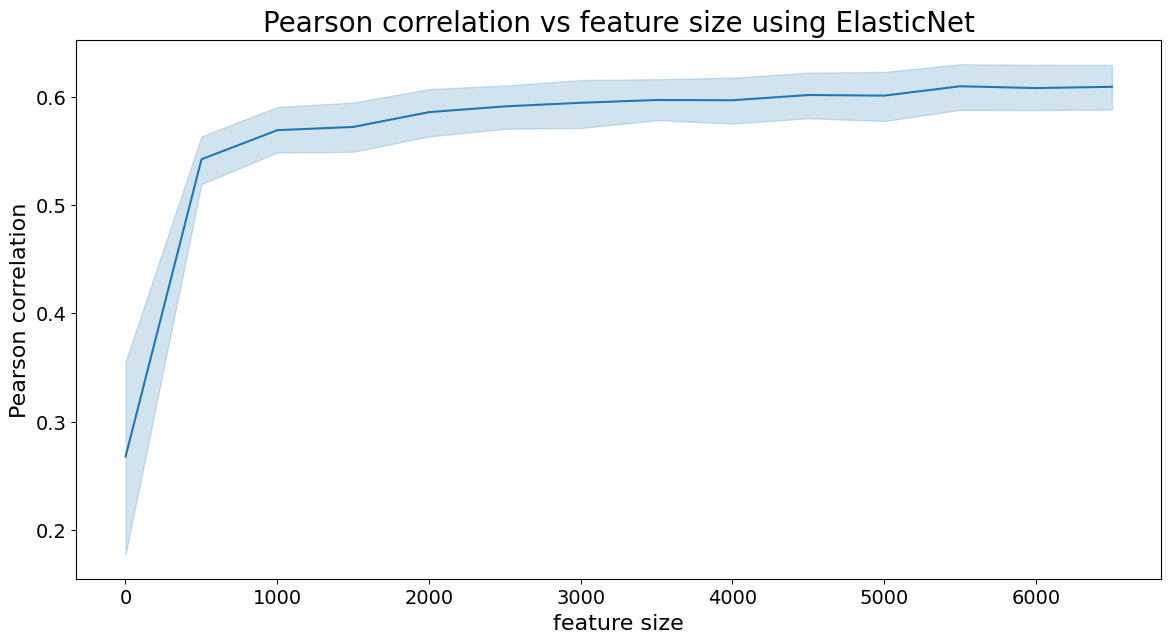

In [6]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


In [7]:
feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    print(f'feature size: {f_size}')
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        random_features = np.random.choice(X_train.columns, f_size, replace=False)
        X_train = X_train[random_features]
        X_test = X_test[random_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1


An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not d

feature size: 11


An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.
An input array is constant; the correlation coefficient is not defined.


feature size: 21
feature size: 31
feature size: 41
feature size: 51
feature size: 61
feature size: 71
feature size: 81
feature size: 91
feature size: 101
feature size: 111
feature size: 121
feature size: 131
feature size: 141
feature size: 151
feature size: 161
feature size: 171
feature size: 181
feature size: 191
feature size: 201
feature size: 211
feature size: 221
feature size: 231
feature size: 241
feature size: 251
feature size: 261
feature size: 271
feature size: 281
feature size: 291
feature size: 301
feature size: 311
feature size: 321
feature size: 331
feature size: 341
feature size: 351
feature size: 361
feature size: 371
feature size: 381
feature size: 391
feature size: 401
feature size: 411
feature size: 421
feature size: 431
feature size: 441
feature size: 451
feature size: 461
feature size: 471
feature size: 481
feature size: 491


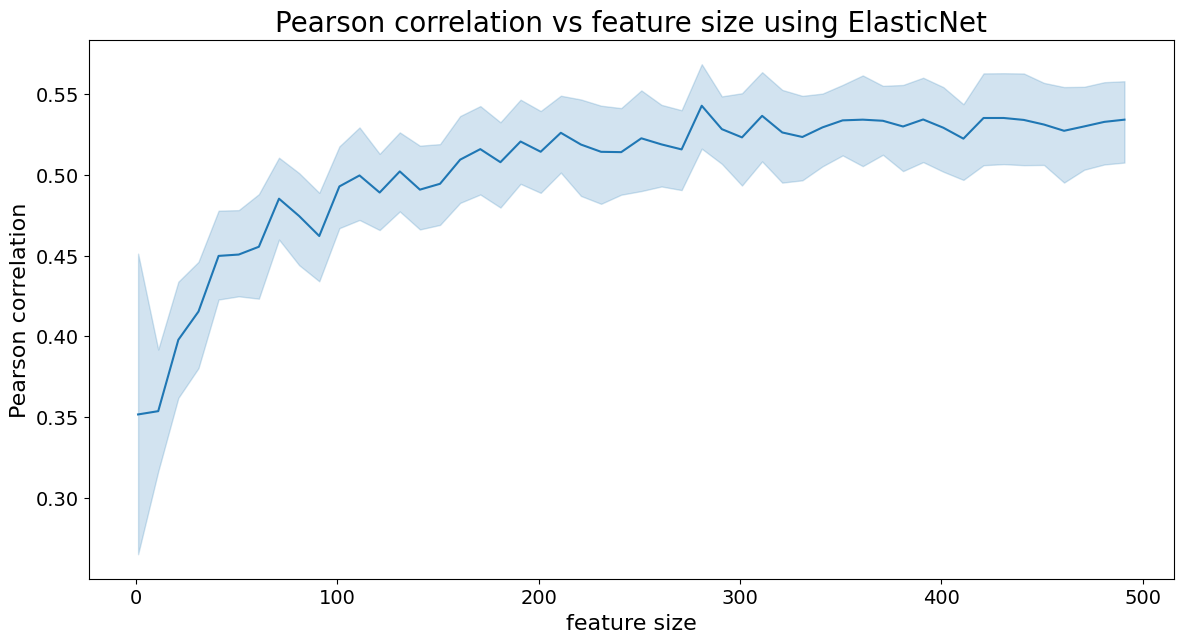

In [8]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()


#### Feature size vs performance with f-regression filtering

In [9]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle

feature_size_tested = []
for i in range(1, 500, 10):
    feature_size_tested.append(i)
n_iterations = 50
cv_split_size = 0.1
rng_seed_list = []
for i in range(n_iterations):
    rng_seed_list.append(np.random.randint(0, 1000000))

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train, y_train)
        selected_features = X_train.columns[selector.get_support()]
        X_train = X_train[selected_features]
        X_test = X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(X_train, y_train)
        # predict the test set
        y_pred = model.predict(X_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1, rng: 59421, mse: 2.8067055264437957, r2: 0.10040697665368825, pearson_corr: 0.46623107824736904
feature size: 1, rng: 660355, mse: 2.1624286606805514, r2: 0.10861715969668895, pearson_corr: 0.45887248456474544
feature size: 1, rng: 183552, mse: 2.615181494097797, r2: 0.17182167791143, pearson_corr: 0.49914540616193304
feature size: 1, rng: 714387, mse: 1.7816160028768309, r2: -0.026659487568975404, pearson_corr: 0.2184257565954998
feature size: 1, rng: 870918, mse: 2.475797452575803, r2: 0.10598415690613094, pearson_corr: 0.5298019168733685
feature size: 1, rng: 14667, mse: 1.9251105142524623, r2: 0.12311065270262112, pearson_corr: 0.4663744344187894
feature size: 1, rng: 772973, mse: 2.215786921662689, r2: 0.08781809383554873, pearson_corr: 0.5192122618667385
feature size: 1, rng: 143580, mse: 2.145652155990583, r2: 0.09290170660613417, pearson_corr: 0.31501707952516256
feature size: 1, rng: 973749, mse: 2.024103564825926, r2: 0.05204062225658246, pearson_corr: 0.2916

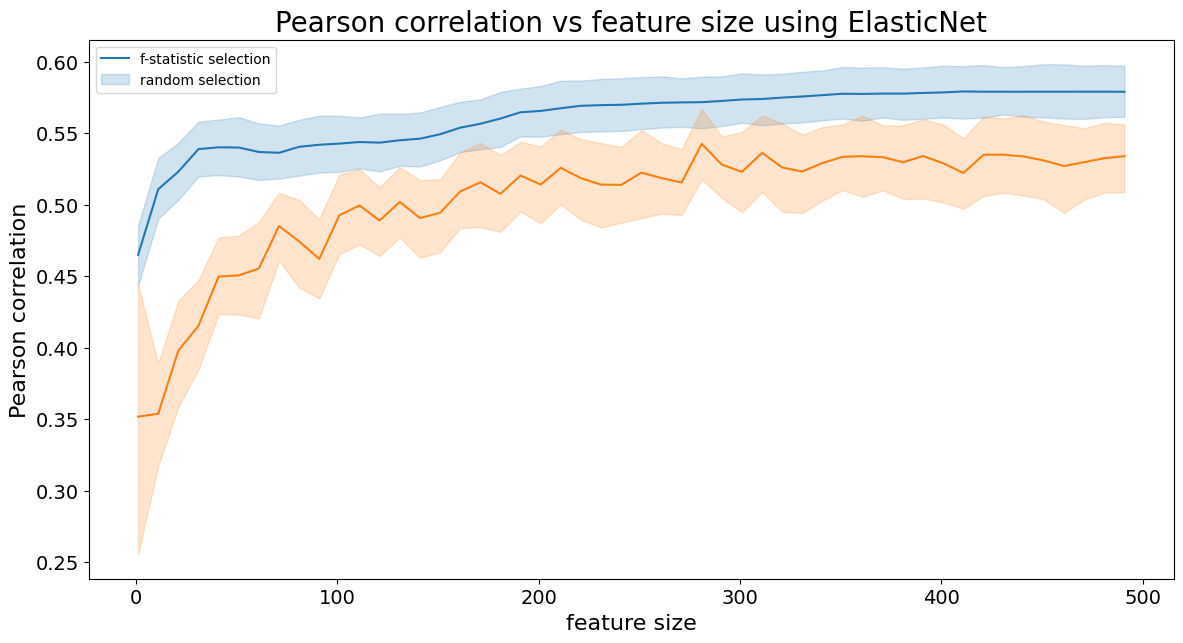

In [10]:
### plot the results

import seaborn as sns

# plot a line plot with error bars for pearson correlation

fig, ax = plt.subplots(figsize=(14, 7))
sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# set the legend
ax.legend(['f-statistic selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

#### Feature size vs performance with network and f-regression filtering

In [11]:
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]
max_gene_target_disance = 2 

data_collector = []
for f_size in feature_size_tested:
    for rng in rng_seed_list:
        X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size, random_state=rng)
        # feature selection
        network_features = nth_degree_neighbours[max_gene_target_disance]
        # perform feature selection on the training set
        selector = SelectKBest(f_regression, k=f_size)
        selector.fit(X_train[network_features], y_train)
        # get the selected features
        selected_features = X_train[network_features].columns[selector.get_support()]
        sel_train, sel_test = X_train[selected_features], X_test[selected_features]
        # train the model
        model = ElasticNet()
        model.fit(sel_train, y_train)
        # predict the test set
        y_pred = model.predict(sel_test)
        # calculate the mean squared error
        mse = mean_squared_error(y_test, y_pred)
        # calculate the r2 score
        r2 = r2_score(y_test, y_pred)
        # calculate the pearson correlation
        pearson_corr, _ = pearsonr(y_test, y_pred)
        # print debug info
        print(f'feature size: {f_size}, rng: {rng}, mse: {mse}, r2: {r2}, pearson_corr: {pearson_corr}')
        # save the data
        data_collector.append([f_size, rng, mse, r2, pearson_corr])

net_stat_df = pd.DataFrame(data_collector, columns=['feature_size', 'rng_seed', 'mse', 'r2', 'pearson_corr'])

feature size: 1, rng: 59421, mse: 2.525338803928644, r2: 0.1905894123212999, pearson_corr: 0.45370692436708204
feature size: 1, rng: 660355, mse: 2.0542543254539996, r2: 0.15320810872333557, pearson_corr: 0.43065097398190566
feature size: 1, rng: 183552, mse: 2.615181494097797, r2: 0.17182167791143, pearson_corr: 0.49914540616193304
feature size: 1, rng: 714387, mse: 1.7816160028768309, r2: -0.026659487568975404, pearson_corr: 0.2184257565954998
feature size: 1, rng: 870918, mse: 2.2132431431476918, r2: 0.200793088895738, pearson_corr: 0.5224509518332581
feature size: 1, rng: 14667, mse: 1.967207838101414, r2: 0.10393528871204627, pearson_corr: 0.32523798388903546
feature size: 1, rng: 772973, mse: 2.0813774044376663, r2: 0.14315099991523783, pearson_corr: 0.44721768019489505
feature size: 1, rng: 143580, mse: 2.145652155990583, r2: 0.09290170660613417, pearson_corr: 0.31501707952516256
feature size: 1, rng: 973749, mse: 2.024103564825926, r2: 0.05204062225658246, pearson_corr: 0.29167

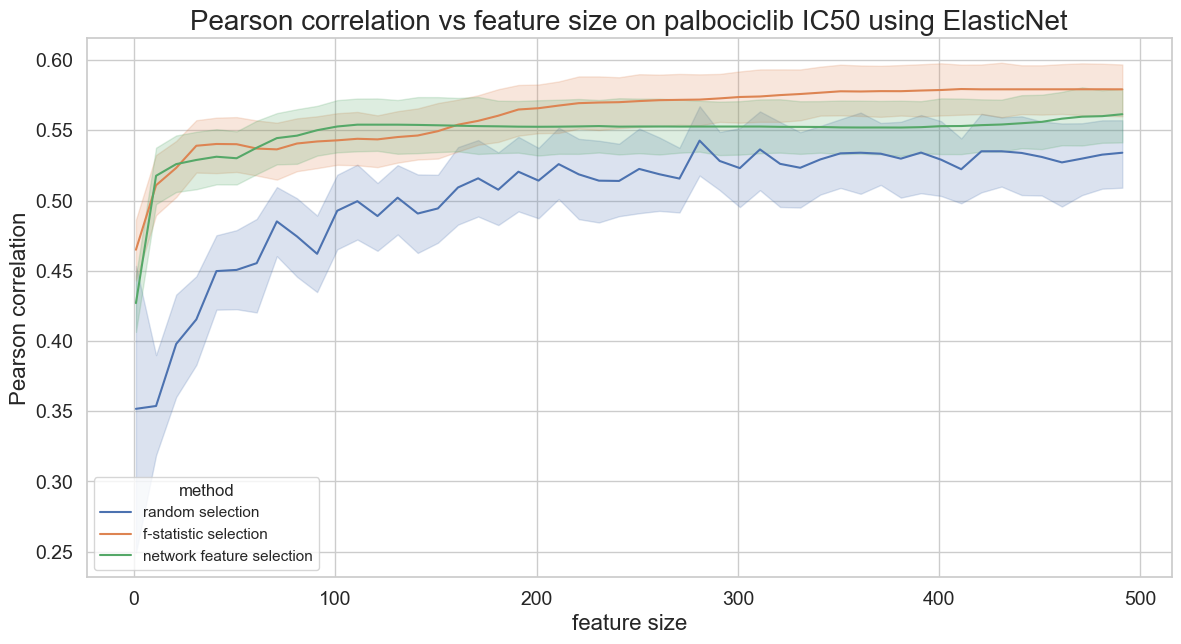

In [12]:
### plot the results

import seaborn as sns

# reindex the dataframes
plotting_df = pd.concat([df, stat_df, net_stat_df], axis=0)
plotting_df['method'] = ['random selection'] * len(df) + ['f-statistic selection'] * len(stat_df) + ['network feature selection'] * len(net_stat_df)
plotting_df.reset_index(inplace=True, drop=True)

# plot a line plot with error bars for pearson correlation
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))
# sns.lineplot(x='feature_size', y='pearson_corr', data=stat_df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=df, ax=ax)
# sns.lineplot(x='feature_size', y='pearson_corr', data=net_stat_df, ax=ax)
sns.lineplot(x='feature_size', y='pearson_corr', hue='method', data=plotting_df, ax=ax)
# set the legend
# ax.legend(['f-statistic selection', 'network feature selection', 'random selection'])
ax.set_title('Pearson correlation vs feature size on palbociclib IC50 using ElasticNet')
ax.set_xlabel('feature size')
ax.set_ylabel('Pearson correlation')
# enlarge the tick labels
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# enlarge the xlabel and ylabel
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
# enlarge the title
ax.title.set_fontsize(20)
plt.show()

In [27]:
plotting_df.head()

,feature_size,rng_seed,mse,r2,pearson_corr,method
0,1,867687,2.091613,-0.021852,NaN,random selection
1,1,489967,2.782423,-0.000004,NaN,random selection
2,1,955061,2.106262,0.173327,0.513515,random selection
3,1,665398,2.468007,-0.001359,NaN,random selection
4,1,894121,2.363915,-0.016337,NaN,random selection


In [29]:
# select feature size 491 with method == 'random selection'

random491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'random selection')]

# select feature size 491 with method == 'f-statistic selection'

fstat491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'f-statistic selection')]

# select feature size 491 with method == 'network feature selection'

net491 = plotting_df[(plotting_df['feature_size'] == 491) & (plotting_df['method'] == 'network feature selection')]

# report the mean and standard deviation of pearson correlation

print(f'random selection: mean: {random491["pearson_corr"].mean()}, std: {random491["pearson_corr"].std()}')
print(f'f-statistic selection: mean: {fstat491["pearson_corr"].mean()}, std: {fstat491["pearson_corr"].std()}')
print(f'network feature selection: mean: {net491["pearson_corr"].mean()}, std: {net491["pearson_corr"].std()}')

# using ANOVA to test if the difference between the means is significant

from scipy.stats import f_oneway

f_oneway(random491['pearson_corr'], fstat491['pearson_corr'], net491['pearson_corr'])

# report the statistic and p-value

from scipy.stats import ttest_rel 

# return the statistic and p-value

f1, p_vals1 = ttest_rel(random491['pearson_corr'], fstat491['pearson_corr'])
f2, p_vals2 = ttest_rel(random491['pearson_corr'], net491['pearson_corr'])
f3, p_vals3 = ttest_rel(fstat491['pearson_corr'], net491['pearson_corr'])

print(f'random vs f-statistic: statistic: {f1}, p-value: {p_vals1}')
print(f'random vs network: statistic: {f2}, p-value: {p_vals2}')
print(f'f-statistic vs network: statistic: {f3}, p-value: {p_vals3}')

# bonferroni correction

print(f'random vs f-statistic: statistic: {f1}, p-value: {p_vals1 * 3}')
print(f'random vs network: statistic: {f2}, p-value: {p_vals2 * 3}')
print(f'f-statistic vs network: statistic: {f3}, p-value: {p_vals3 * 3}')




random selection: mean: 0.534007860298804, std: 0.08948661956480572
f-statistic selection: mean: 0.5791248778410405, std: 0.06672865444961742
network feature selection: mean: 0.5614208721987086, std: 0.07059911823299712
random vs f-statistic: statistic: -3.023844025737089, p-value: 0.003964901759265217
random vs network: statistic: -1.8037692771900393, p-value: 0.0774168301439566
f-statistic vs network: statistic: 3.8904694473884147, p-value: 0.00030182724616173044
random vs f-statistic: statistic: -3.023844025737089, p-value: 0.011894705277795653
random vs network: statistic: -1.8037692771900393, p-value: 0.2322504904318698
f-statistic vs network: statistic: 3.8904694473884147, p-value: 0.0009054817384851913


### Validation Framework Implementation

#### Initial Parameters

In [30]:
import Visualisation as vis
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model
from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model
from sklearn.svm import SVR

# import elastic net regression model
from sklearn.linear_model import ElasticNet

# import simple mlp regression model
from sklearn.neural_network import MLPRegressor

# import xgb regression model
from xgboost import XGBRegressor

# import k nearest neighbors regression model
from sklearn.neighbors import KNeighborsRegressor

## feature selection
# import feature selection
from sklearn.feature_selection import SelectKBest, f_regression
import shap 

## validation
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

## saving and loading files
import pickle


## INPUTS 
# file names 
folder_path = 'data/processed-results/workbook-jun-2023/'
input_parameter_file_path = folder_path + 'input_parameters_test.pkl'
output_file_path = folder_path + 'results_test.pkl'
experiment_name = 'test'
save_input = True
save_output = True

# hyperparameters
max_gene_target_disance = 3 # specify the level of biological relevance to drug target(s)
statistical_filter_size = 100 # can be optimized using global feature dropout testing
monte_carlo_cross_validation_size = 50 # can be automatically optimized via rank impact assessment
models_used = ['ElasticNet']
models_hyperparameters = [{}]

# extra hyperparameters
statistical_filter_threshold = 0.05 # currently not in use
cv_split_size = 0.1

# generated hyperparameters
rng_seed_lists = []
for j in range(monte_carlo_cross_validation_size):
    rng_seed_lists.append(np.random.randint(100000))

def get_model_from_string(model_name, **kwargs):
    if model_name == 'ElasticNet':
        return ElasticNet(**kwargs)
    elif model_name == 'RandomForestRegressor':
        return RandomForestRegressor(**kwargs)
    elif model_name == 'SVR':
        return SVR(**kwargs)
    elif model_name == 'MLPRegressor':
        return MLPRegressor(**kwargs)
    elif model_name == 'XGBRegressor':
        return XGBRegressor(**kwargs)
    elif model_name == 'KNeighborsRegressor':
        return KNeighborsRegressor(**kwargs)
    else:
        raise ValueError(f'{model_name} is not supported')
    
nth_degree_neighbours = [drug_targets, first_degree_neighbours, second_degree_neighbours, third_degree_neighbours]

if save_input:
    # save initial parameters as pickle 
    with open(input_parameter_file_path, 'wb') as f:
        # dump each variable individually
        pickle.dump(max_gene_target_disance, f)
        pickle.dump(statistical_filter_size, f)
        pickle.dump(monte_carlo_cross_validation_size, f)
        pickle.dump(models_used, f)
        pickle.dump(models_hyperparameters, f)
        pickle.dump(statistical_filter_threshold, f)
        pickle.dump(cv_split_size, f)
        pickle.dump(input_parameter_file_path, f)
        pickle.dump(output_file_path, f)
        pickle.dump(rng_seed_lists, f)
        pickle.dump(nth_degree_neighbours, f)
        pickle.dump(experiment_name, f)

In [31]:
network_features = nth_degree_neighbours[max_gene_target_disance]
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=cv_split_size,
                                                    random_state=rng_seed_lists[0])

if statistical_filter_size > len(network_features):
    statistical_filter_size = len(network_features)
    print(f'WARNING: statistical_filter_size is too large, set to {statistical_filter_size}')

# perform feature selection on the training set
selector = SelectKBest(f_regression, k=statistical_filter_size)
selector.fit(X_train[network_features], y_train)

# get the selected features
selected_features = X_train[network_features].columns[selector.get_support()]

# get the feature importance
feature_importance = selector.scores_[selector.get_support()]

# DEBUG print the selected features and their importance
# print(f'selected features: {selected_features}')
# print(f'feature importance: {feature_importance}')

In [32]:
X_train.shape

(663, 6692)

#### Feature Selection and Consensus Feature Contribution

In [77]:
from toolkit import *

tool = Toolkit(feature_data=feature_data, label_data=label_data)

tool.add_condition('network_stat',
                True,
                impute_with_network_stat_selection,
                (nth_degree_neighbours, 3, 100))

tool.add_model('ElasticNet',
            'ElasticNet', 
            {'alpha': 0.005})

rng_seed_lists, shap_df = tool.run_until_consensus('network_stat')

shap_contribs = get_mean_contribution(shap_df, 'network_stat')

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.686e+00, tolerance: 1.762e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.568e+01, tolerance: 1.749e-01


current iteration: 2 current_tol: 0.3935743442139541, abs_diff: 3.2895763272350855, abs_prev: 8.358208240948787, corr: 0.4152950796023349


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e+01, tolerance: 1.668e-01


current iteration: 3 current_tol: 0.24847383096921927, abs_diff: 2.0261091114935477, abs_prev: 8.154215289353914, corr: 0.5987117860453226


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e+01, tolerance: 1.695e-01


current iteration: 4 current_tol: 0.15674229961569253, abs_diff: 1.227151794334675, abs_prev: 7.829104187851389, corr: 0.5674943781336191


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.714e+00, tolerance: 1.732e-01


current iteration: 5 current_tol: 0.14903234600813065, abs_diff: 1.1344974062875024, abs_prev: 7.612423991672312, corr: 0.6184655988844004


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.012e+00, tolerance: 1.713e-01


current iteration: 6 current_tol: 0.11917558284100149, abs_diff: 0.9226793820262998, abs_prev: 7.74218476663375, corr: 0.4939854429506499


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.720e+01, tolerance: 1.695e-01


current iteration: 7 current_tol: 0.0909274921691704, abs_diff: 0.7106640702662471, abs_prev: 7.815722762308877, corr: 0.5332048497069486


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.539e+01, tolerance: 1.723e-01


current iteration: 8 current_tol: 0.0759282928672711, abs_diff: 0.5849490719750476, abs_prev: 7.703967123264405, corr: 0.5852740560562928


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.950e+00, tolerance: 1.654e-01


current iteration: 9 current_tol: 0.06430696388149004, abs_diff: 0.48707178861108125, abs_prev: 7.574168631389536, corr: 0.6544715554951689


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e+01, tolerance: 1.648e-01


current iteration: 10 current_tol: 0.062230153809288535, abs_diff: 0.47281779133136514, abs_prev: 7.597888843089955, corr: 0.6302807010168274


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e+00, tolerance: 1.697e-01


current iteration: 11 current_tol: 0.06737044509318757, abs_diff: 0.5104012166856849, abs_prev: 7.576040442952288, corr: 0.5149614398133436


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.230e+00, tolerance: 1.706e-01


current iteration: 12 current_tol: 0.04902527168792137, abs_diff: 0.37499242122105986, abs_prev: 7.6489616132703375, corr: 0.6820585074835639


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+01, tolerance: 1.749e-01


current iteration: 13 current_tol: 0.05291150081814189, abs_diff: 0.40718051234390457, abs_prev: 7.695501092350291, corr: 0.4807183817506092


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e+01, tolerance: 1.703e-01


current iteration: 14 current_tol: 0.05193984604167423, abs_diff: 0.40142346406395724, abs_prev: 7.728622525023906, corr: 0.6426124503589226


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+01, tolerance: 1.757e-01


current iteration: 15 current_tol: 0.03821491422188572, abs_diff: 0.29697090948220073, abs_prev: 7.771073559341529, corr: 0.5530491027414516


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+01, tolerance: 1.703e-01


current iteration: 16 current_tol: 0.033906265929337875, abs_diff: 0.26232269880836157, abs_prev: 7.73670268955755, corr: 0.576322290461979


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e+01, tolerance: 1.762e-01


current iteration: 17 current_tol: 0.0406314160379917, abs_diff: 0.3115385217254109, abs_prev: 7.667429592759259, corr: 0.5228094577011135


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.389e+00, tolerance: 1.688e-01


current iteration: 18 current_tol: 0.039398508636524276, abs_diff: 0.30318699992987613, abs_prev: 7.6953928060314345, corr: 0.632150539359798


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.062e+00, tolerance: 1.719e-01


current iteration: 19 current_tol: 0.03222048568094771, abs_diff: 0.24874907595887236, abs_prev: 7.720214971990931, corr: 0.6219270376001748


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+00, tolerance: 1.662e-01


current iteration: 20 current_tol: 0.029286949186406508, abs_diff: 0.22659398320048207, abs_prev: 7.737029273969428, corr: 0.7014872679999934


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.597e+00, tolerance: 1.768e-01


current iteration: 21 current_tol: 0.033503591346633166, abs_diff: 0.259211743908497, abs_prev: 7.736834574737191, corr: 0.48094001849707685


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e+01, tolerance: 1.734e-01


current iteration: 22 current_tol: 0.024711790866223105, abs_diff: 0.19147291216014994, abs_prev: 7.748241039942658, corr: 0.5108545526215184


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+01, tolerance: 1.691e-01


current iteration: 23 current_tol: 0.024849584646520317, abs_diff: 0.19207180574962288, abs_prev: 7.7293769083789865, corr: 0.6455603486175489


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.512e+00, tolerance: 1.747e-01


current iteration: 24 current_tol: 0.02396659471983753, abs_diff: 0.18461412423282986, abs_prev: 7.702976847187302, corr: 0.4643849520471172


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e+01, tolerance: 1.719e-01


current iteration: 25 current_tol: 0.02973211699426992, abs_diff: 0.22888015403704526, abs_prev: 7.698077943160112, corr: 0.5258637525385261


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.445e+00, tolerance: 1.724e-01


current iteration: 26 current_tol: 0.022006587025080848, abs_diff: 0.1693282119644125, abs_prev: 7.69443311547717, corr: 0.5497852529765342


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+01, tolerance: 1.669e-01


current iteration: 27 current_tol: 0.02455971535091539, abs_diff: 0.18903938826545025, abs_prev: 7.697132705506079, corr: 0.5655093433238699


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e+01, tolerance: 1.701e-01


current iteration: 28 current_tol: 0.022729480156427728, abs_diff: 0.17571224739521452, abs_prev: 7.730588037471003, corr: 0.47092385992819885


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.796e+00, tolerance: 1.663e-01


current iteration: 29 current_tol: 0.023720929449011496, abs_diff: 0.18322504944879311, abs_prev: 7.724193516221099, corr: 0.6078713347593617


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.828e+00, tolerance: 1.673e-01


current iteration: 30 current_tol: 0.018506074402836248, abs_diff: 0.14269094188930714, abs_prev: 7.710492175879181, corr: 0.712289473641984


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+01, tolerance: 1.781e-01


current iteration: 31 current_tol: 0.01971056125223236, abs_diff: 0.1518843249835223, abs_prev: 7.705733136661481, corr: 0.524265622942761


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e+01, tolerance: 1.710e-01


current iteration: 32 current_tol: 0.02010479121217046, abs_diff: 0.15519477866994924, abs_prev: 7.719293228770339, corr: 0.6851201311989054


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e+00, tolerance: 1.783e-01


current iteration: 33 current_tol: 0.017204828284807627, abs_diff: 0.1333394422299986, abs_prev: 7.7501175845934664, corr: 0.5102876608045419


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.314e+01, tolerance: 1.766e-01


current iteration: 34 current_tol: 0.019944387219758553, abs_diff: 0.15432026051068082, abs_prev: 7.737528298578101, corr: 0.5365246268196768


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e+00, tolerance: 1.732e-01


current iteration: 35 current_tol: 0.016772425834306715, abs_diff: 0.1298258981707398, abs_prev: 7.740436562562735, corr: 0.4219711827457923


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e+00, tolerance: 1.712e-01


current iteration: 36 current_tol: 0.015134121884359142, abs_diff: 0.1171238079861048, abs_prev: 7.739055419340204, corr: 0.600487912292505


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+01, tolerance: 1.786e-01


current iteration: 37 current_tol: 0.01712619121697123, abs_diff: 0.13275020004394317, abs_prev: 7.751297317782702, corr: 0.5672682423264302


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.768e+01, tolerance: 1.716e-01


current iteration: 38 current_tol: 0.019009447625235043, abs_diff: 0.14740363888613453, abs_prev: 7.754230516959194, corr: 0.550190405882815


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e+00, tolerance: 1.667e-01


current iteration: 39 current_tol: 0.015478841133856003, abs_diff: 0.12023131799629838, abs_prev: 7.767462496486442, corr: 0.6256015255750671


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e+01, tolerance: 1.722e-01


current iteration: 40 current_tol: 0.015071927534175411, abs_diff: 0.11694532988785483, abs_prev: 7.759148896030914, corr: 0.5626592057922406


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e+01, tolerance: 1.716e-01


current iteration: 41 current_tol: 0.014823089094878616, abs_diff: 0.11512459294996306, abs_prev: 7.766572285512235, corr: 0.6467317802031609


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e+01, tolerance: 1.751e-01


current iteration: 42 current_tol: 0.01596935636088992, abs_diff: 0.12408036802333296, abs_prev: 7.76990413509804, corr: 0.6409872885531351


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+00, tolerance: 1.756e-01


current iteration: 43 current_tol: 0.012820911844084182, abs_diff: 0.09966170122488519, abs_prev: 7.773370758404441, corr: 0.6390292851541167


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.254e+01, tolerance: 1.757e-01


current iteration: 44 current_tol: 0.012091630337991655, abs_diff: 0.09407924014816665, abs_prev: 7.780525662662003, corr: 0.5713417258629634


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.717e+01, tolerance: 1.787e-01


current iteration: 45 current_tol: 0.014121105740840134, abs_diff: 0.10956474924308884, abs_prev: 7.758935543284905, corr: 0.5867395720528192


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e+01, tolerance: 1.725e-01


current iteration: 46 current_tol: 0.012028725131673523, abs_diff: 0.0933131604781908, abs_prev: 7.757527041039703, corr: 0.6006604580774452


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e+01, tolerance: 1.710e-01


current iteration: 47 current_tol: 0.011601348346945484, abs_diff: 0.08991343284016663, abs_prev: 7.750257138329921, corr: 0.5784240373298415


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.076e+01, tolerance: 1.661e-01


current iteration: 48 current_tol: 0.01431044503563672, abs_diff: 0.11069016361051251, abs_prev: 7.734921124735492, corr: 0.6581816429194908


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.407e+01, tolerance: 1.741e-01


current iteration: 49 current_tol: 0.010937279062151029, abs_diff: 0.08467905690284569, abs_prev: 7.742241596073119, corr: 0.4534972673751532


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.905e+01, tolerance: 1.660e-01


current iteration: 50 current_tol: 0.014412605899414066, abs_diff: 0.11158762307106199, abs_prev: 7.742362751735224, corr: 0.6150549016153695


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.771e+00, tolerance: 1.734e-01


current iteration: 51 current_tol: 0.01153249165785375, abs_diff: 0.08923966647558054, abs_prev: 7.738108044917398, corr: 0.6319919660876298


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e+01, tolerance: 1.721e-01


current iteration: 52 current_tol: 0.012683528875999883, abs_diff: 0.0982386992644314, abs_prev: 7.745375930063243, corr: 0.5012542827998295


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e+01, tolerance: 1.672e-01


current iteration: 53 current_tol: 0.01122493168278682, abs_diff: 0.0871373831596006, abs_prev: 7.762843073087307, corr: 0.6069974695031551


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.595e+01, tolerance: 1.749e-01


current iteration: 54 current_tol: 0.011737248245424436, abs_diff: 0.09106215664571887, abs_prev: 7.758390616064356, corr: 0.5537678690074942


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+01, tolerance: 1.719e-01


current iteration: 55 current_tol: 0.010018158428869883, abs_diff: 0.07767635828472248, abs_prev: 7.753556587893231, corr: 0.5539723732797522


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e+01, tolerance: 1.723e-01


current iteration: 56 current_tol: 0.010014491461562414, abs_diff: 0.07761415021754277, abs_prev: 7.750183872585212, corr: 0.4924623187508096


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+01, tolerance: 1.697e-01


current iteration: 57 current_tol: 0.012169638577250064, abs_diff: 0.09419361214770247, abs_prev: 7.740050088569411, corr: 0.6504131011269184


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.594e+01, tolerance: 1.671e-01


current iteration: 58 current_tol: 0.010161883575777853, abs_diff: 0.07858435644645971, abs_prev: 7.7332470757464336, corr: 0.6634723323433768


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.125e+00, tolerance: 1.718e-01


current iteration: 59 current_tol: 0.010808500844159963, abs_diff: 0.08357170203827563, abs_prev: 7.7320345571727085, corr: 0.6464490960352942


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.501e-01, tolerance: 1.744e-01


current iteration: 60 current_tol: 0.010913751407996997, abs_diff: 0.08439068859305968, abs_prev: 7.732509697006936, corr: 0.5834285192661093
current iteration: 61 current_tol: 0.00953346587856041, abs_diff: 0.0737737588699111, abs_prev: 7.738398585536396, corr: 0.6650364030827748
Consensus Run: condition network_stat is done in 61 iterations
Consensus Run under condition network_stat is NOT converged within 0.001 absolute tolerance


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e+00, tolerance: 1.694e-01


### Plotting mean contribution


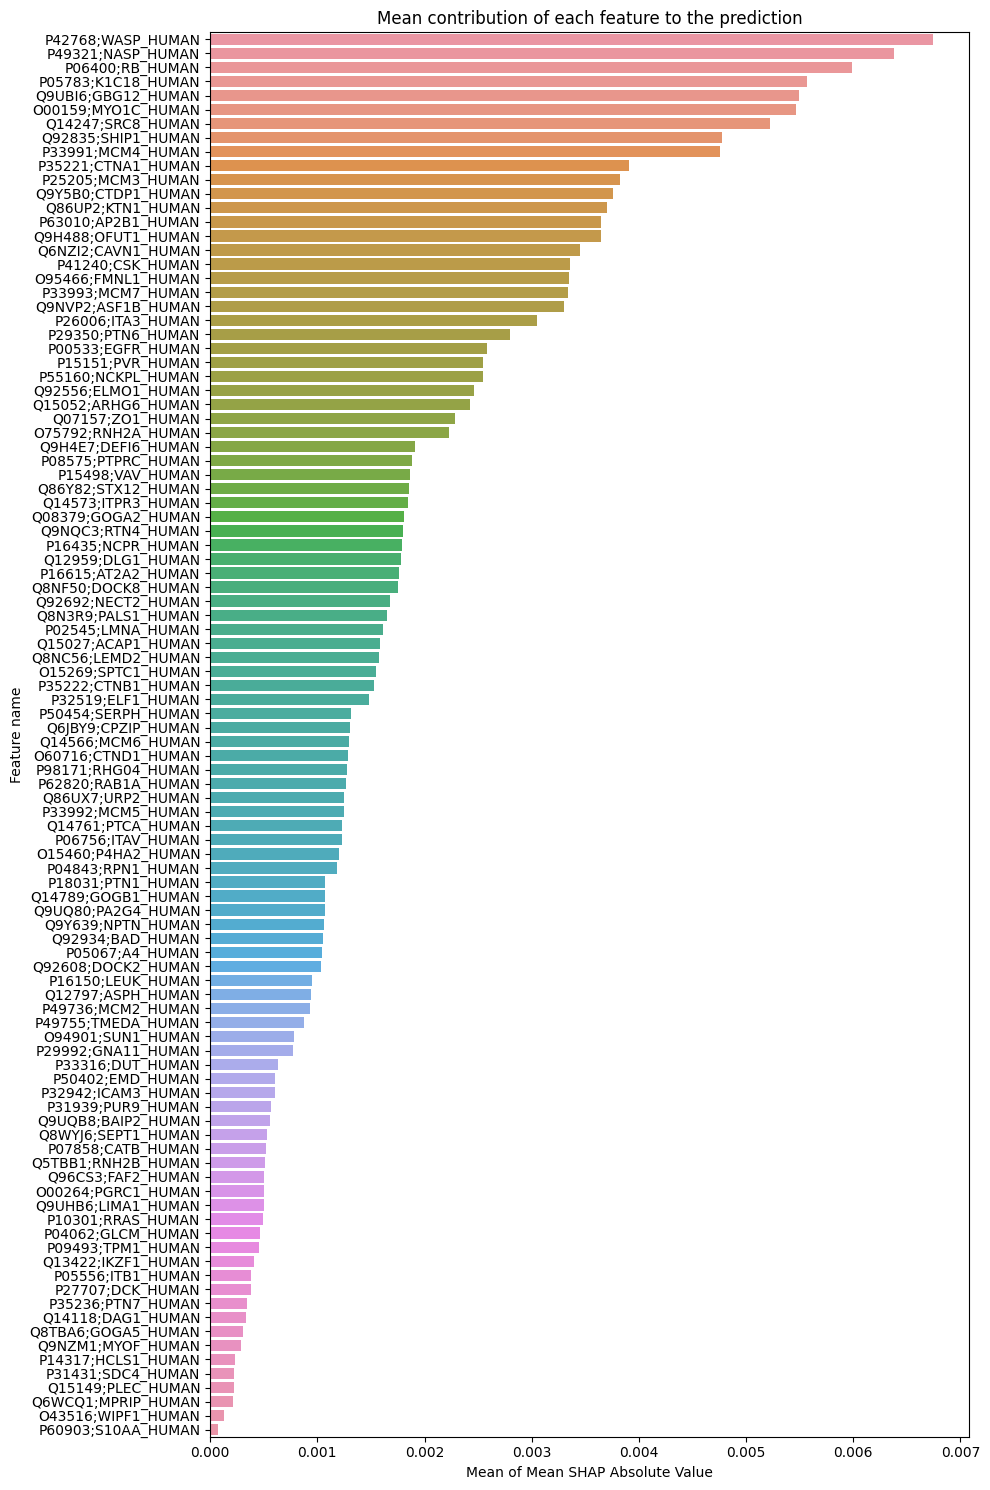

In [78]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns

plot_shap_values = np.abs(shap_contribs)
# sort the values
plot_shap_values.sort_values(inplace=True, ascending=False)

print('### Plotting mean contribution')
plt.figure(figsize=(10, 15))
sns.barplot(x=plot_shap_values.values, y=plot_shap_values.index)
plt.title('Mean contribution of each feature to the prediction')
plt.xlabel('Mean of Mean SHAP Absolute Value')
plt.ylabel('Feature name')
plt.tight_layout()
# plt.savefig('mean_contribution.png', dpi=300)
plt.show()

#### in silico Knockout Validation 

are the features really important? Knock them out and check if the model performance decreases, compare it with a random feature knockout. If not, then what new features are contributing to the model performance?

In [79]:
# get the feature with the highest mean shap value
abs_shap_contribs = np.abs(shap_contribs)
abs_shap_contribs.sort_values(inplace=True, ascending=False)
highest_mean_shap = abs_shap_contribs.index[0]

# get all of the consensus features
consensus_features = [x for x in abs_shap_contribs.index]

In [80]:
highest_mean_shap

'P42768;WASP_HUMAN'

In [81]:
knockout_features = []
for feature in consensus_features:
    if feature != highest_mean_shap:
        knockout_features.append(feature)

# knockout top 10 features with the highest feature importance
knockout_features_2 = consensus_features.copy()
# remove the first 10 elements in the list
knockout_features_2 = knockout_features_2[10:]



tool.add_condition('knockout-1',
                True,
                impute_with_preset_features,
                (knockout_features,))


tool.add_condition('knockout-2',
                True,
                impute_with_preset_features,
                (knockout_features_2,))


In [82]:
if 'O00159;MYO1C_HUMAN' in knockout_features:
    print('yes')

yes


In [83]:

rng_seed_lists_k1, shap_df_k1 = tool.run_until_consensus('knockout-1')


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.764e+00, tolerance: 1.709e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e+01, tolerance: 1.759e-01


current iteration: 2 current_tol: 0.1802832506095594, abs_diff: 1.4314830400351446, abs_prev: 7.940188759605385, corr: 0.6092388907264958


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.032e+01, tolerance: 1.739e-01


current iteration: 3 current_tol: 0.1156339101642666, abs_diff: 0.909024722018503, abs_prev: 7.861229640398441, corr: 0.5024179056597379


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.913e+00, tolerance: 1.724e-01


current iteration: 4 current_tol: 0.08799013111592713, abs_diff: 0.6902278912519119, abs_prev: 7.844378483111198, corr: 0.5523004082568934


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.546e+00, tolerance: 1.728e-01


current iteration: 5 current_tol: 0.05460802129650788, abs_diff: 0.42231428757519496, abs_prev: 7.733557773172817, corr: 0.5555730045841747


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.249e+00, tolerance: 1.699e-01


current iteration: 6 current_tol: 0.0492652326546682, abs_diff: 0.369202698522915, abs_prev: 7.494183598216103, corr: 0.6574984559084442


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.654e+00, tolerance: 1.714e-01


current iteration: 7 current_tol: 0.051350461132277925, abs_diff: 0.3866480544731604, abs_prev: 7.529592645276577, corr: 0.6333773564441605


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.938e+00, tolerance: 1.723e-01


current iteration: 8 current_tol: 0.0382382002941547, abs_diff: 0.2888993929669975, abs_prev: 7.555256020016186, corr: 0.608267821244911


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.057e+00, tolerance: 1.744e-01


current iteration: 9 current_tol: 0.033255458759621326, abs_diff: 0.25077588564119746, abs_prev: 7.540893886139649, corr: 0.4783022256188879


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.947e+00, tolerance: 1.774e-01


current iteration: 10 current_tol: 0.0304552407908133, abs_diff: 0.22802896813705117, abs_prev: 7.487347406093591, corr: 0.4577426714225131


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+01, tolerance: 1.716e-01


current iteration: 11 current_tol: 0.028278012684180398, abs_diff: 0.21121640340949605, abs_prev: 7.469280312178974, corr: 0.4821903083579346


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.429e+00, tolerance: 1.728e-01


current iteration: 12 current_tol: 0.024537175719041127, abs_diff: 0.18222190943815858, abs_prev: 7.426360373527106, corr: 0.6708415007740698


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+01, tolerance: 1.765e-01


current iteration: 13 current_tol: 0.024468322343087046, abs_diff: 0.18151223372707667, abs_prev: 7.418254148444233, corr: 0.33282359493284835


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.638e+00, tolerance: 1.724e-01


current iteration: 14 current_tol: 0.02689334704191293, abs_diff: 0.19839756516609197, abs_prev: 7.377198712264836, corr: 0.4735950010019128


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.316e+00, tolerance: 1.709e-01


current iteration: 15 current_tol: 0.020188639312587853, abs_diff: 0.1499865854746776, abs_prev: 7.4292567791411095, corr: 0.6614561928264496


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e+00, tolerance: 1.752e-01


current iteration: 16 current_tol: 0.017583873285417106, abs_diff: 0.1302287263998726, abs_prev: 7.406145636176492, corr: 0.5530569896022215


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.963e-01, tolerance: 1.705e-01


current iteration: 17 current_tol: 0.021108287520717584, abs_diff: 0.15587433919948954, abs_prev: 7.384509001334228, corr: 0.6306863611549066


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.723e+00, tolerance: 1.752e-01


current iteration: 18 current_tol: 0.01560616447142582, abs_diff: 0.11594767993855865, abs_prev: 7.429607713724554, corr: 0.5508141565906988


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.764e+00, tolerance: 1.722e-01


current iteration: 19 current_tol: 0.019761272166601618, abs_diff: 0.14616573721246934, abs_prev: 7.3965752801838125, corr: 0.5441666491629533


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.880e+00, tolerance: 1.738e-01


current iteration: 20 current_tol: 0.0123970373595641, abs_diff: 0.09139347108065862, abs_prev: 7.372202602112093, corr: 0.5775404514271805


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.851e+00, tolerance: 1.728e-01


current iteration: 21 current_tol: 0.010270924335443854, abs_diff: 0.07546672731038731, abs_prev: 7.347608145642703, corr: 0.6496476999520715


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.225e+00, tolerance: 1.619e-01


current iteration: 22 current_tol: 0.016391506650958676, abs_diff: 0.12020503779830093, abs_prev: 7.333373335224808, corr: 0.5866992085825639


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.631e+00, tolerance: 1.699e-01


current iteration: 23 current_tol: 0.013060526715088061, abs_diff: 0.09538591172255277, abs_prev: 7.303374037155741, corr: 0.517574793001196


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.166e+00, tolerance: 1.742e-01


current iteration: 24 current_tol: 0.010847686078167995, abs_diff: 0.07920447671128072, abs_prev: 7.301508924625668, corr: 0.4970561630123416


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.366e+00, tolerance: 1.759e-01


current iteration: 25 current_tol: 0.012181354801990785, abs_diff: 0.08891451014931993, abs_prev: 7.299229978490503, corr: 0.5006959733691471


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e+00, tolerance: 1.711e-01


current iteration: 26 current_tol: 0.012154226877607699, abs_diff: 0.0886383341698462, abs_prev: 7.292799045338578, corr: 0.6683307405270412


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+00, tolerance: 1.726e-01


current iteration: 27 current_tol: 0.01164295410664673, abs_diff: 0.0850791324390541, abs_prev: 7.30734929123217, corr: 0.6549512900662999
current iteration: 28 current_tol: 0.008078578471931719, abs_diff: 0.05926314472597752, abs_prev: 7.335838221028872, corr: 0.6734529769814978
Consensus Run: condition knockout-1 is done in 28 iterations
Consensus Run under condition knockout-1 is NOT converged within 0.001 absolute tolerance


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e+00, tolerance: 1.721e-01


In [84]:

rng_seed_lists_k2, shap_df_k2 = tool.run_until_consensus('knockout-2')

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.992e+00, tolerance: 1.772e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e+00, tolerance: 1.762e-01


current iteration: 2 current_tol: 0.16679137604124017, abs_diff: 1.0628810985440795, abs_prev: 6.372518314623626, corr: 0.532968495853597


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e+00, tolerance: 1.716e-01


current iteration: 3 current_tol: 0.13049474075489653, abs_diff: 0.8471046273117157, abs_prev: 6.491484809359487, corr: 0.6535890957507507


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e+00, tolerance: 1.761e-01


current iteration: 4 current_tol: 0.07454641422845909, abs_diff: 0.4812150926817649, abs_prev: 6.455241310561317, corr: 0.4748647458639903


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e+00, tolerance: 1.680e-01


current iteration: 5 current_tol: 0.061481612791858264, abs_diff: 0.38661770699462583, abs_prev: 6.288346864020849, corr: 0.6743729101525897


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e+00, tolerance: 1.727e-01


current iteration: 6 current_tol: 0.05309951496528342, abs_diff: 0.33788063650536726, abs_prev: 6.363158622565095, corr: 0.47952295984674737


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e+00, tolerance: 1.729e-01


current iteration: 7 current_tol: 0.042729477869550614, abs_diff: 0.27263895226546153, abs_prev: 6.380582348743053, corr: 0.6180057316304332


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.318e+00, tolerance: 1.694e-01


current iteration: 8 current_tol: 0.0435148798484426, abs_diff: 0.2783481308149627, abs_prev: 6.396619542198391, corr: 0.6006009397138063


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.238e+00, tolerance: 1.731e-01


current iteration: 9 current_tol: 0.028109420854850464, abs_diff: 0.17774076226320784, abs_prev: 6.323174112373713, corr: 0.5206563128244451


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.706e+00, tolerance: 1.699e-01


current iteration: 10 current_tol: 0.03258094630914654, abs_diff: 0.20480565505914852, abs_prev: 6.28605606220999, corr: 0.5524130706824231


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e+00, tolerance: 1.743e-01


current iteration: 11 current_tol: 0.02948348735755557, abs_diff: 0.18621693981746512, abs_prev: 6.31597400806606, corr: 0.4079113880714391


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.388e+00, tolerance: 1.670e-01


current iteration: 12 current_tol: 0.027423432021360106, abs_diff: 0.1723891913050741, abs_prev: 6.286200471582122, corr: 0.7067309349767246


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.590e+00, tolerance: 1.696e-01


current iteration: 13 current_tol: 0.023650362051262808, abs_diff: 0.1496400899170902, abs_prev: 6.32717966823261, corr: 0.6606499161191196


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+00, tolerance: 1.689e-01


current iteration: 14 current_tol: 0.026653867767472472, abs_diff: 0.16825326795164652, abs_prev: 6.312527300708593, corr: 0.5384218316166223
current iteration: 15 current_tol: 0.017016613584319384, abs_diff: 0.10840217994295764, abs_prev: 6.370373247638941, corr: 0.5033358651084701


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.352e+00, tolerance: 1.728e-01


current iteration: 16 current_tol: 0.016936796073571125, abs_diff: 0.10815249134603724, abs_prev: 6.385652332131607, corr: 0.5548485157251946


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+01, tolerance: 1.743e-01


current iteration: 17 current_tol: 0.017453594171596643, abs_diff: 0.11148332214601231, abs_prev: 6.387413449055474, corr: 0.6422969385918271


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e+00, tolerance: 1.718e-01


current iteration: 18 current_tol: 0.015851957257284166, abs_diff: 0.10169031157621199, abs_prev: 6.41500036403919, corr: 0.6219935538452502


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+01, tolerance: 1.734e-01


current iteration: 19 current_tol: 0.018040423335396905, abs_diff: 0.11578547907772237, abs_prev: 6.418113196409368, corr: 0.47761973432397165


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+00, tolerance: 1.690e-01


current iteration: 20 current_tol: 0.013563759117827145, abs_diff: 0.08685120156926392, abs_prev: 6.4031807712592705, corr: 0.6591670152454705


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.720e+00, tolerance: 1.701e-01


current iteration: 21 current_tol: 0.012638940100447638, abs_diff: 0.08101071178895156, abs_prev: 6.409612763817283, corr: 0.7156891947252202


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e+00, tolerance: 1.723e-01


current iteration: 22 current_tol: 0.014274551829026372, abs_diff: 0.09173576800733617, abs_prev: 6.4265252672099376, corr: 0.6818924426620836


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+00, tolerance: 1.720e-01


current iteration: 23 current_tol: 0.012509933927228656, abs_diff: 0.08067466583606929, abs_prev: 6.448848275727169, corr: 0.6045504946400173


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e+00, tolerance: 1.719e-01


current iteration: 24 current_tol: 0.01049259281918069, abs_diff: 0.06728461617700321, abs_prev: 6.412582412805144, corr: 0.6994948133400728


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.143e-01, tolerance: 1.687e-01


current iteration: 25 current_tol: 0.014806870205993139, abs_diff: 0.0944652517480396, abs_prev: 6.379825745335745, corr: 0.6407451026293837


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e+01, tolerance: 1.720e-01


current iteration: 26 current_tol: 0.010649616032246567, abs_diff: 0.06814949573712514, abs_prev: 6.3992443981802944, corr: 0.5972817801341855


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.968e+00, tolerance: 1.748e-01


current iteration: 27 current_tol: 0.01146570829927851, abs_diff: 0.07350316964948825, abs_prev: 6.41069594053017, corr: 0.5240043949946264
current iteration: 28 current_tol: 0.009882533538894567, abs_diff: 0.06330924499164817, abs_prev: 6.406175576584982, corr: 0.5123824081405084
Consensus Run: condition knockout-2 is done in 28 iterations
Consensus Run under condition knockout-2 is NOT converged within 0.001 absolute tolerance


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e+00, tolerance: 1.736e-01


In [85]:
shap_df['corr'].mean()

0.5763571092030644

In [86]:
shap_df_k1['corr'].mean()
# shap_df_k1['corr'].std()

0.5660809187695341

In [87]:
shap_df_k2['corr'].mean()


0.586920543321611

In [88]:
knockout_mean_shap_values = get_mean_contribution(shap_df_k1, condition='knockout-1')
knockout_mean_shap_values_2 = get_mean_contribution(shap_df_k2, condition='knockout-2')

In [89]:
mean_shap_values_1 = shap_contribs
mean_shap_values_2 = knockout_mean_shap_values


def get_diff_between_feature_contributions(shap_df1: pd.DataFrame, shap_df2: pd.DataFrame):
    # compute the difference in mean shap values for each feature
    diff = shap_df2 - shap_df1
    diff = diff.sort_values(ascending=False)
    return diff

def get_abs_sum_for_feature_contributions(shap_df):
    return shap_df.abs().sum()

total_sum_og = get_abs_sum_for_feature_contributions(shap_contribs)
total_sum_ko = get_abs_sum_for_feature_contributions(knockout_mean_shap_values)
total_sum_ko_2 = get_abs_sum_for_feature_contributions(knockout_mean_shap_values_2)

print(f'### Total absolute sum of mean shap values: {total_sum_og}')
print(f'### Total absolute sum of mean shap values for knockout 1: {total_sum_ko}')
print(f'### Total absolute sum of mean shap values for knockout 2: {total_sum_ko_2}')

# compute the total absolute change in mean shap values by summing the absolute change for each feature
diff = get_diff_between_feature_contributions(mean_shap_values_1, mean_shap_values_2)
total_abs_change = get_abs_sum_for_feature_contributions(diff)
print(f'### Total absolute change in mean shap values: {total_abs_change}')

# compute total absolute change in mean shap values for each feature between knockout 2 and original 
diff2 = get_diff_between_feature_contributions(mean_shap_values_1, knockout_mean_shap_values_2)
abs_change_2 = get_abs_sum_for_feature_contributions(diff2)
print(f'### Total absolute change in mean shap values for knockout 2: {abs_change_2}')


from scipy.stats import ttest_rel
def report_ttest_for_performance(df1, df2, condition1, condition2, verbose=True):
    if verbose:
        print(f'### Running t-test for performance between {condition1} and {condition2}')
        print(f'Mean performance of {condition1}: {df1[df1["exp_condition"]==condition1]["corr"].mean():.3f}, variance: {df1[df1["exp_condition"]==condition1]["corr"].var():.3f}')
        print(f'Mean performance of {condition2}: {df2[df2["exp_condition"]==condition2]["corr"].mean():.3f}, variance: {df2[df2["exp_condition"]==condition2]["corr"].var():.3f}')
    t_stat, p_val = ttest_rel(df1[df1['exp_condition']==condition1]['corr'], df2[df2['exp_condition']==condition2]['corr'])
    if verbose:
        print(f'### t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}')
    return t_stat, p_val

# t_stat, p_val = report_ttest_for_performance(shap_df, shap_df_k1, 'network_stat', 'knockout-1')

# t_stat, p_val = report_ttest_for_performance(shap_df, shap_df_k2, 'network_stat', 'knockout-2')

### Total absolute sum of mean shap values: 0.18404651275287778
### Total absolute sum of mean shap values for knockout 1: 0.20002268913764545
### Total absolute sum of mean shap values for knockout 2: 0.1547735089809367
### Total absolute change in mean shap values: 0.2776640190472922
### Total absolute change in mean shap values for knockout 2: 0.20941204412933656


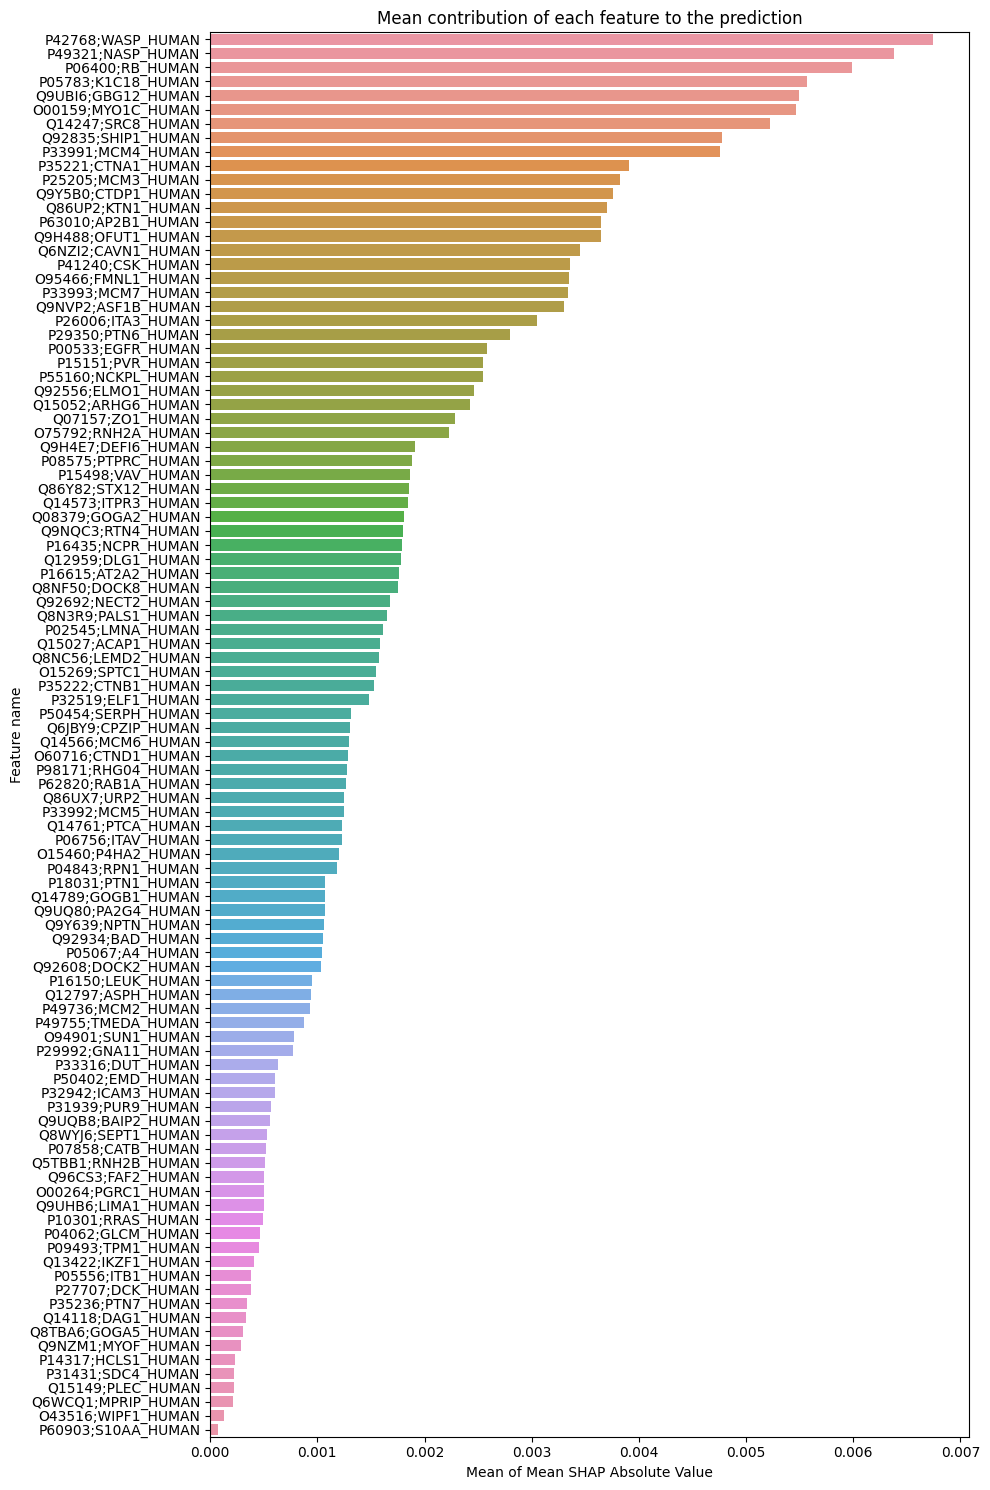

In [90]:
# plot the mean shap values

import matplotlib.pyplot as plt
import seaborn as sns


def plot_mean_shap_value_df(mean_shap_values, title, absolute=True):
    if absolute:
        plot_shap_values = np.abs(mean_shap_values)
        # sort the values
        plot_shap_values.sort_values(inplace=True, ascending=False)
    else:
        plot_shap_values = mean_shap_values
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.barplot(x=plot_shap_values.values, y=plot_shap_values.index, ax=ax)
    plt.title(title)
    plt.xlabel('Mean of Mean SHAP Absolute Value')
    plt.ylabel('Feature name')
    plt.tight_layout()
    # plt.savefig('mean_contribution.png', dpi=300)
    return fig, ax

fig, ax = plot_mean_shap_value_df(mean_shap_values_1, 'Mean contribution of each feature to the prediction')
plt.show()

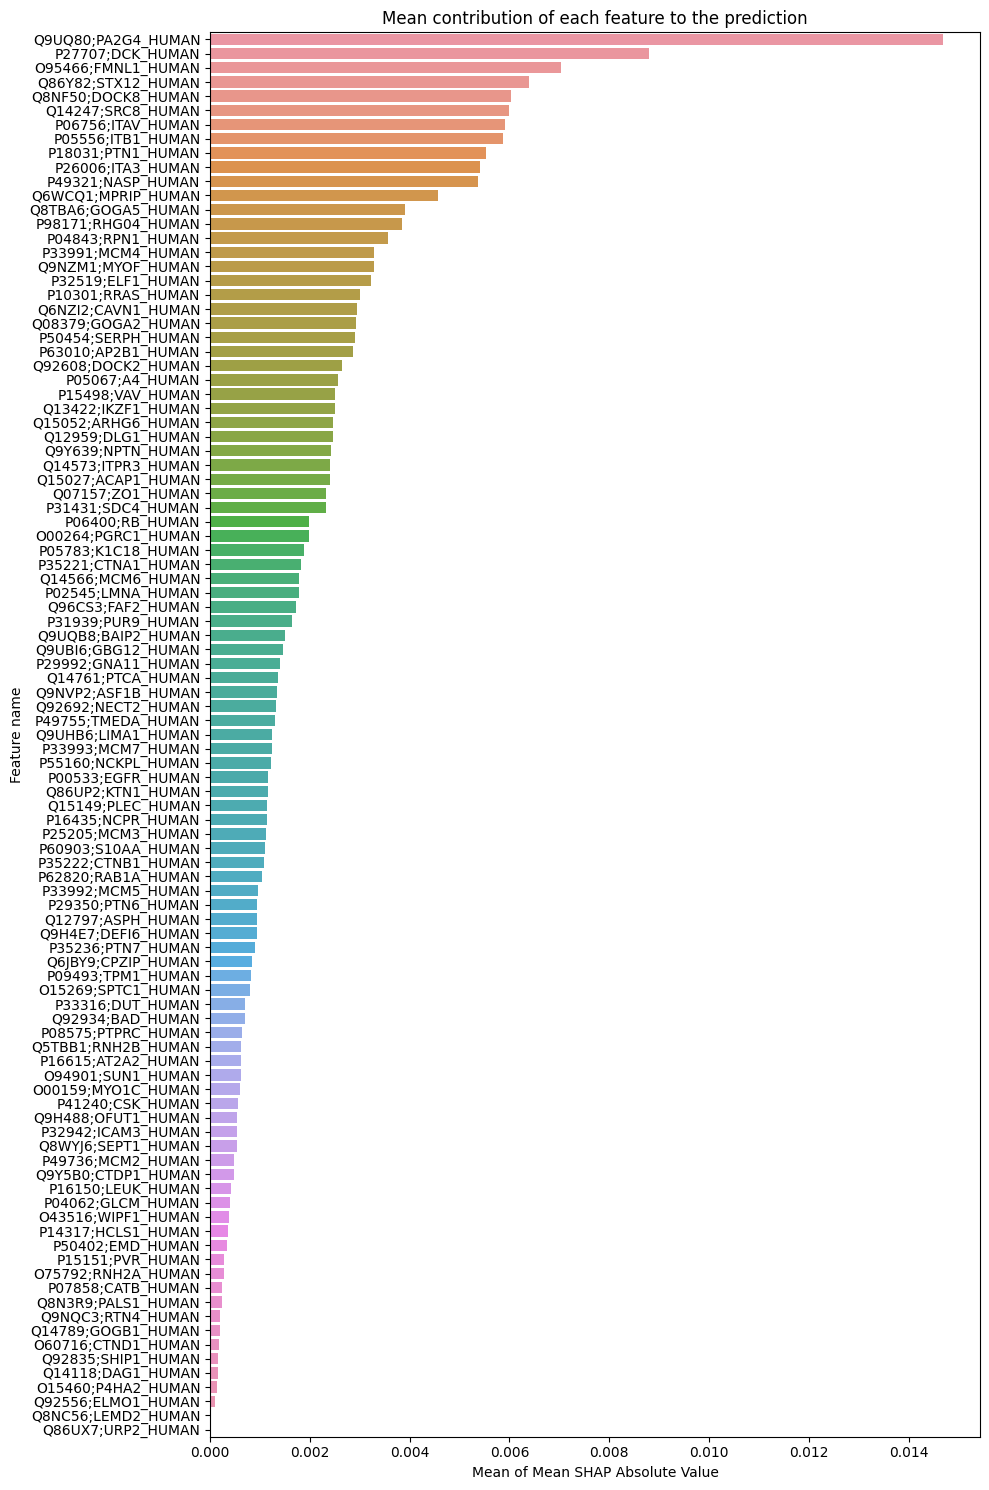

In [91]:
plot_mean_shap_value_df(mean_shap_values_2, 'Mean contribution of each feature to the prediction')
plt.show()

#### Calculate the difference in mean contribution of features between two mean shap values

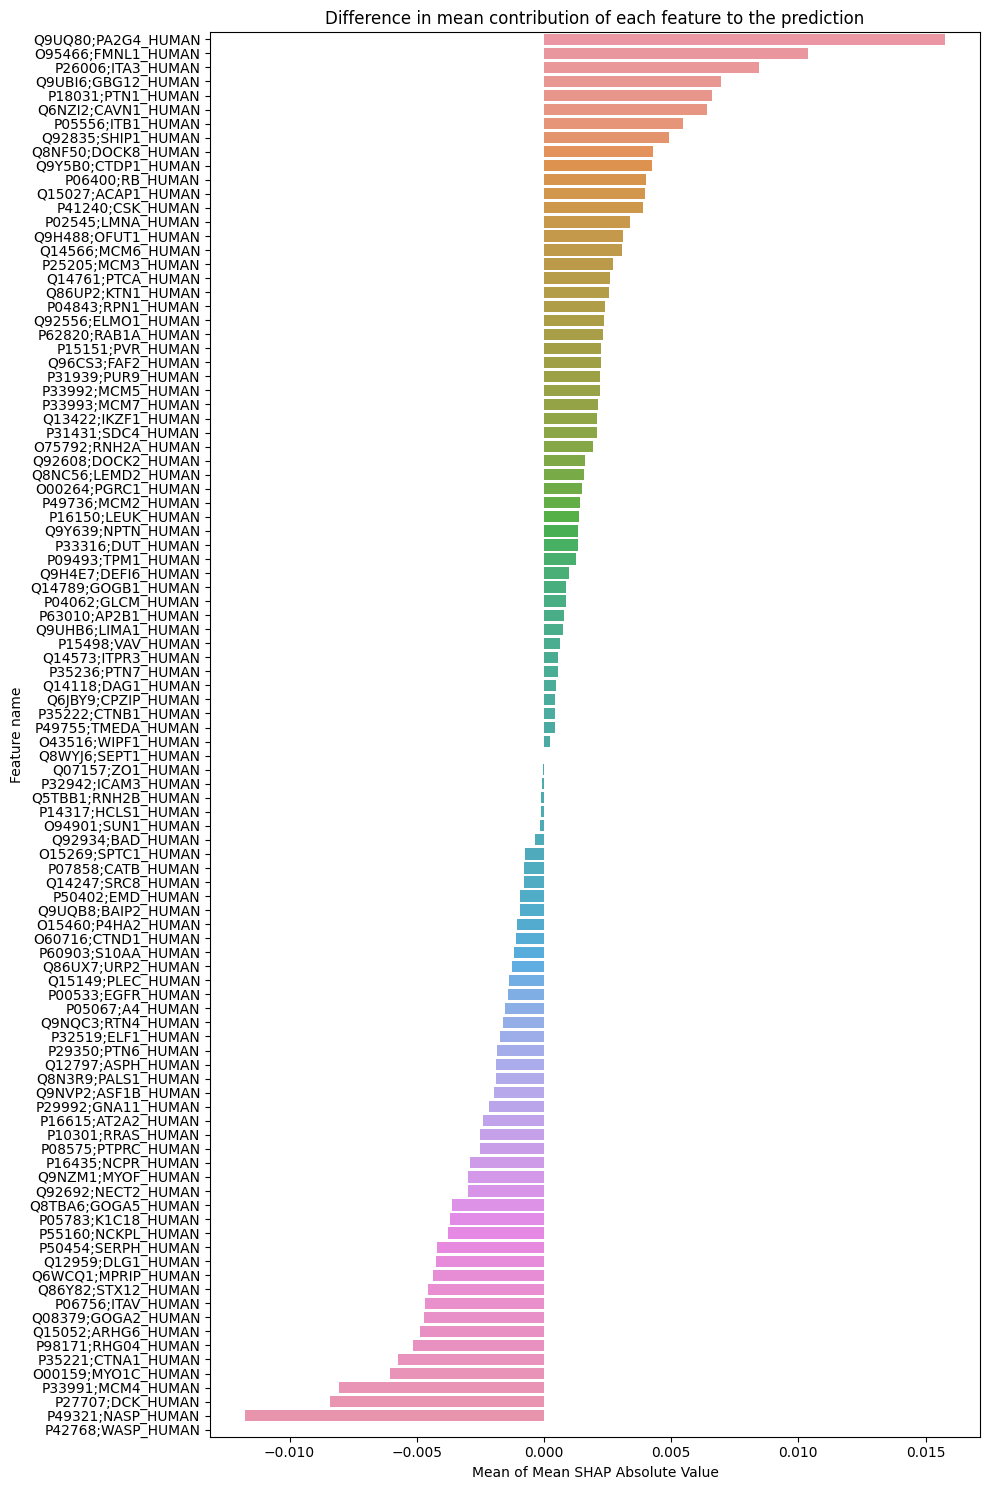

In [92]:
fig, ax = plot_mean_shap_value_df(diff, 'Difference in mean contribution of each feature to the prediction', absolute=False)
plt.show()


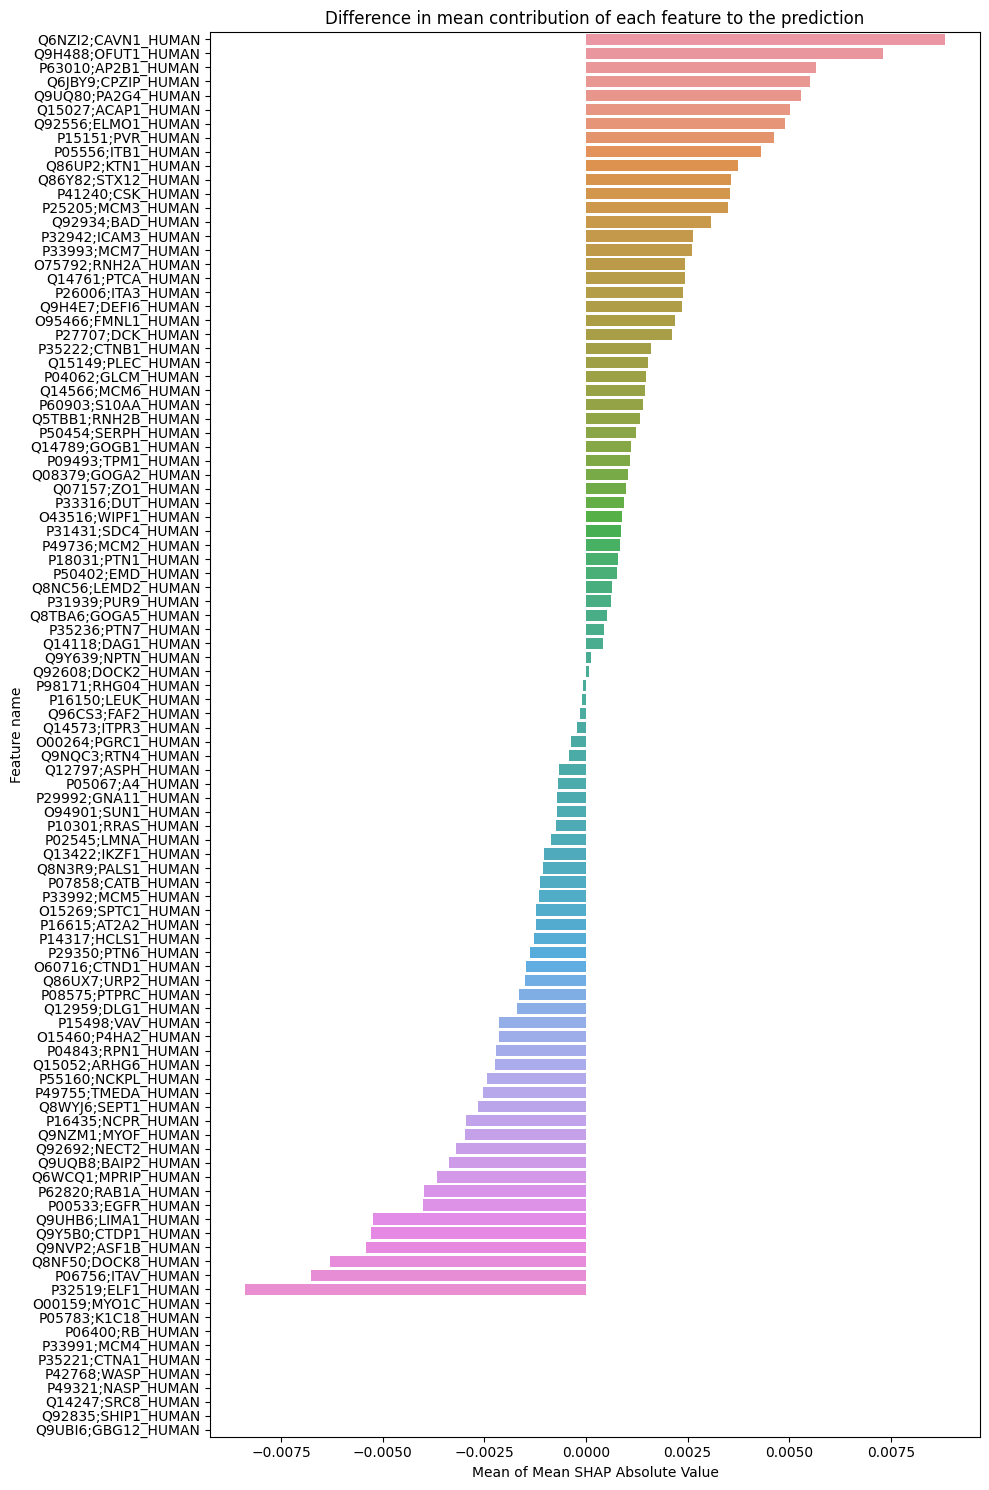

In [93]:
fig, ax = plot_mean_shap_value_df(diff2, 'Difference in mean contribution of each feature to the prediction', absolute=False)
plt.show()

conclusion: when one protein gets knocked out, another protein of statistically similar shape will take its place and contribute to the model performance.

mean absolute change in shap value between two mean shap values is highly interesting and should be explored further. Mean absolute change, in this case, represents the total perturbation effect of any n-sized feature set on the holistic feature contribution landscape. This will allow for the quantification, and visualisation for the explanation of model performance between different *in silico* experimental conditions.

model performance between different conditions can now be directly compared using pearson correlation coefficient, r2 and mean squared error.

One interesting hypothesis is that when mean absolute change in feature contribution is low between two conditions, model performance drops proportionally to the knocked out features. This can be that the model can no longer compensate for the loss of the feature by adjusting contribution of still-existing features and the model performance drops.

This feature selection approach is model-agnostic and can be applied to any model. It is scalable with increased computational power and can be used to compare model performance between different conditions. Filtering selection and in addition, even the global feature importance approaches can be substituted (e.g. lime) 

We can also select any n-feature combination, knock them out and compare the model performance with the original model performance, while similarly comparing the mean absolute change in feature contribution between the two conditions. If n is small (e.g. less than 3), we can experimentally validate the results using in vitro experiments. Specifically, once the n-feature combination is selected, we assess their correlation with LN_IC50 of the drug of interest. If a featuer correlation is *positive*, then the cell lines are resistant to drug when expression is high, *knockout* of the feature should *increase* the drug sensitivity. If a feature correlation is *negative*, then *overexpression* of the feature should *increase* the drug sensitivity.